# 1. Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    mean_squared_error, r2_score, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb


# 2. Loading the Dataset

In [2]:
df = pd.read_csv('credit.csv')
print(df.head())

   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines   age  \
0           0                 1                              0.766127  45.0   
1           1                 0                              0.957151  40.0   
2           2                 0                              0.658180  38.0   
3           3                 0                              0.233810  30.0   
4           4                 0                              0.907239  49.0   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                   2.0   0.802982         9120.0   
1                                   0.0   0.121876         2600.0   
2                                   1.0   0.085113         3042.0   
3                                   0.0   0.036050         3300.0   
4                                   1.0   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                             13.0             

# 3. Dataset Overview and Summary Statistics

In [3]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  float64
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  float64
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  float64
 8   NumberOfTimes90DaysLate               150000 non-null  float64
 9   NumberRealEstateLoansOrLines          150000 non-null  float64
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  float64
 11  

In [5]:
print(df.isnull().sum())

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [6]:
# Class distribution
print(df['SeriousDlqin2yrs'].value_counts(normalize=True))


SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


In [7]:
# Standardize column names
df.columns = [c.strip().replace(' ', '').replace('-', '') for c in df.columns]

# Keeping only relevant columns
keep_cols = [
    'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfTime30_59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60_89DaysPastDueNotWorse',
    'NumberOfDependents'
]
df = df[[c for c in keep_cols if c in df.columns]]


In [8]:

print("Dataset shape:", df.shape)
print("Target default rate:", df['SeriousDlqin2yrs'].mean())
print(df.isnull().sum())

Dataset shape: (150000, 9)
Target default rate: 0.06684
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfDependents                       3924
dtype: int64


In [9]:
# Check dataset dimensions
print("Dataset Shape:", df.shape)
# Get column names and data types
print("\nColumn Data Types:\n", df.dtypes)


Dataset Shape: (150000, 9)

Column Data Types:
 SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                     float64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans         float64
NumberOfTimes90DaysLate                 float64
NumberRealEstateLoansOrLines            float64
NumberOfDependents                      float64
dtype: object


In [10]:

# Summary statistics for numerical columns
print("\nStatistical Summary:\n", df.describe())



Statistical Summary:
        SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     150000.000000                         150000.000000  150000.000000   
mean           0.066840                              6.048438      52.295207   
std            0.249746                            249.755371      14.771866   
min            0.000000                              0.000000       0.000000   
25%            0.000000                              0.029867      41.000000   
50%            0.000000                              0.154181      52.000000   
75%            0.000000                              0.559046      63.000000   
max            1.000000                          50708.000000     109.000000   

           DebtRatio  MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
count  150000.000000   1.202690e+05                    150000.000000   
mean      353.005076   6.670221e+03                         8.452760   
std      2037.818523   1.438467e+04     

In [11]:

# Check for null values
print("\nMissing Values per Column:\n", df.isnull().sum())



Missing Values per Column:
 SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfDependents                       3924
dtype: int64


In [12]:

# Count of unique values in each column
print("\nUnique Values per Column:\n", df.nunique())


Unique Values per Column:
 SeriousDlqin2yrs                             2
RevolvingUtilizationOfUnsecuredLines    125728
age                                         86
DebtRatio                               114194
MonthlyIncome                            13594
NumberOfOpenCreditLinesAndLoans             58
NumberOfTimes90DaysLate                     19
NumberRealEstateLoansOrLines                28
NumberOfDependents                          13
dtype: int64


In [13]:
# Identify any duplicated rows
print("\nNumber of Duplicate Rows:", df.duplicated().sum())



Number of Duplicate Rows: 638


In [14]:
# Check basic info (non-null counts and memory usage)
print("\nDataset Info:")
print(df.info())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  float64
 3   DebtRatio                             150000 non-null  float64
 4   MonthlyIncome                         120269 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       150000 non-null  float64
 6   NumberOfTimes90DaysLate               150000 non-null  float64
 7   NumberRealEstateLoansOrLines          150000 non-null  float64
 8   NumberOfDependents                    146076 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 10.3 MB
None


In [38]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfDependents,MonthsToRepay_proxy
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,146076.000000,150000.000000
mean,0.066840,6.048438,52.295207,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.757222,8.692607
std,0.249746,249.755371,14.771866,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,1.115086,8.414325
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.154181,52.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,5.000000
75%,0.000000,0.559046,63.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,1.000000,11.000000
max,1.000000,50708.000000,109.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,20.000000,24.000000


# 4. Exploratory Data Analysis (EDA)

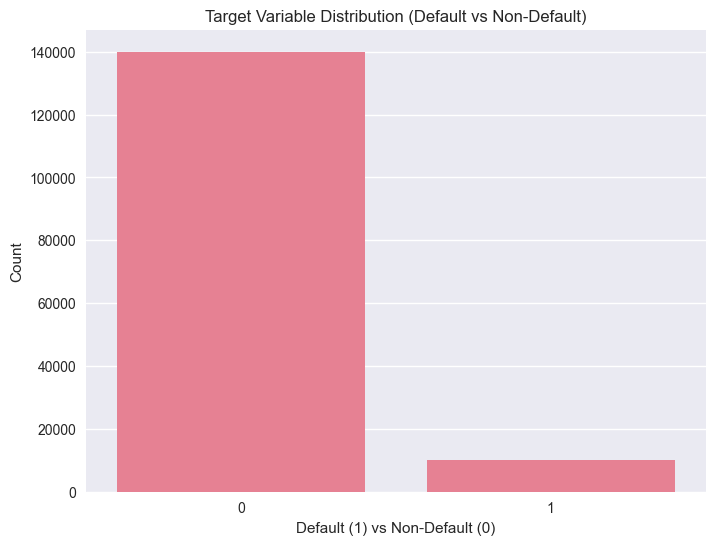

In [16]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Class distribution (bar plot)
plt.figure(figsize=(8, 6))
sns.countplot(x='SeriousDlqin2yrs', data=df)
plt.title("Target Variable Distribution (Default vs Non-Default)")
plt.xlabel("Default (1) vs Non-Default (0)")
plt.ylabel("Count")
plt.show()


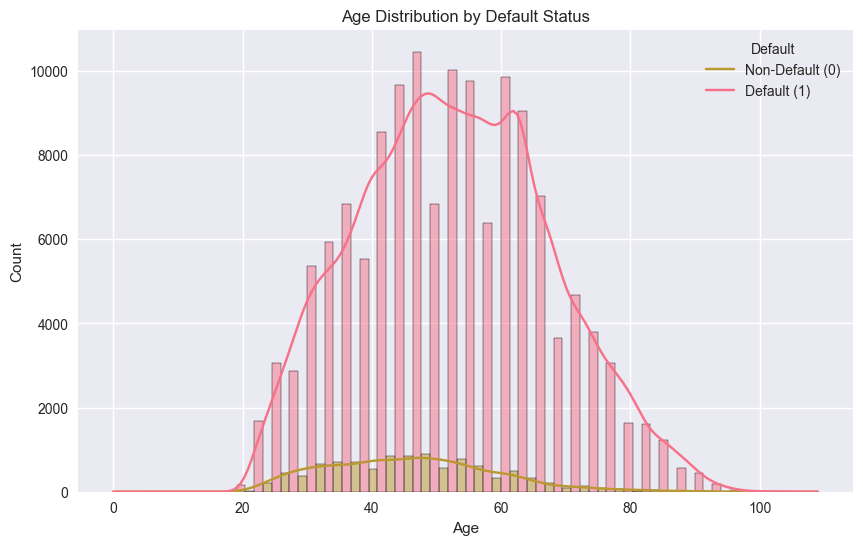

In [17]:
# 2. Age distribution with default overlay (histogram with hue)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='SeriousDlqin2yrs', multiple='dodge', bins=40, kde=True)
plt.title("Age Distribution by Default Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="Default", labels=["Non-Default (0)", "Default (1)"])
plt.show()

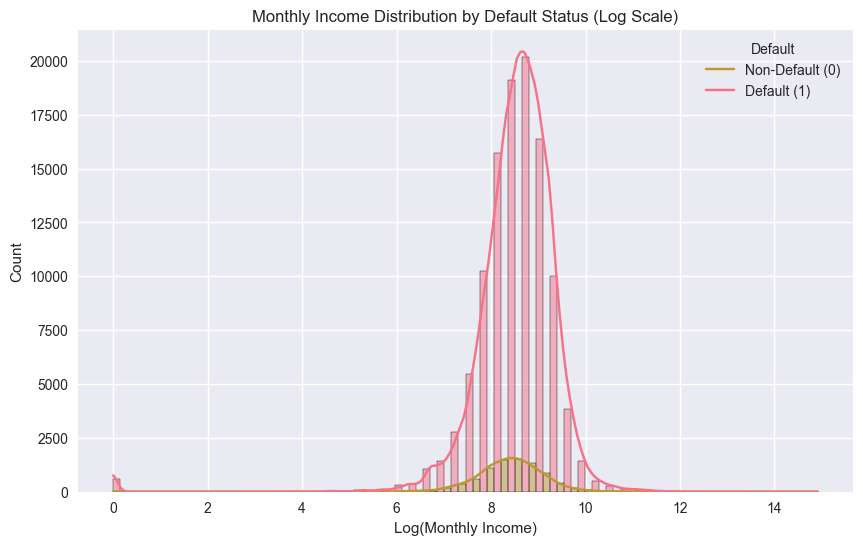

In [18]:
# 3. Monthly Income distribution (log scale histogram with hue)
plt.figure(figsize=(10, 6))
df_income = df[df['MonthlyIncome'] > 0].copy()  # Avoid log(0)
df_income.loc[:, 'log_income'] = np.log(df_income['MonthlyIncome'])
sns.histplot(data=df_income, x='log_income', hue='SeriousDlqin2yrs', multiple='dodge', bins=50, kde=True)
plt.title("Monthly Income Distribution by Default Status (Log Scale)")
plt.xlabel("Log(Monthly Income)")
plt.ylabel("Count")
plt.legend(title="Default", labels=["Non-Default (0)", "Default (1)"])
plt.show()


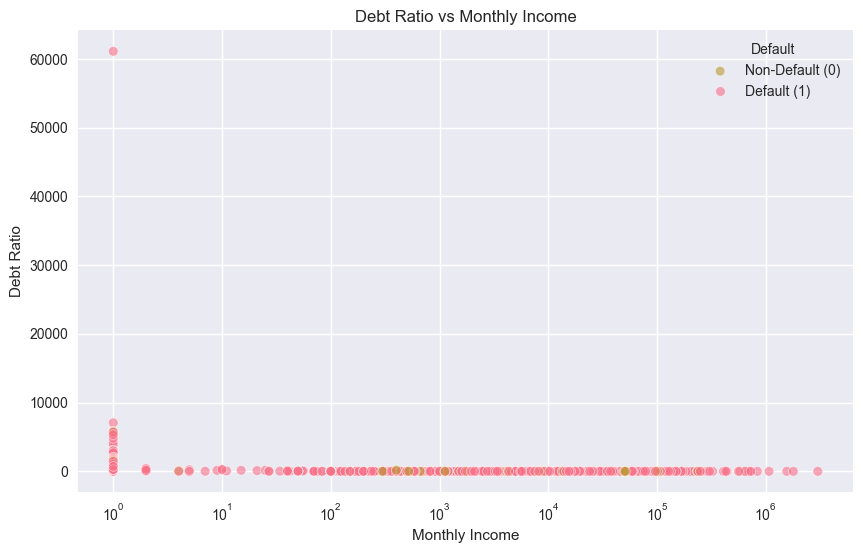

In [19]:
# 4. Debt ratio vs income scatter plot with hue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MonthlyIncome', y='DebtRatio', hue='SeriousDlqin2yrs', alpha=0.6)
plt.title("Debt Ratio vs Monthly Income")
plt.xlabel("Monthly Income")
plt.ylabel("Debt Ratio")
plt.xscale('log')  # Log scale for x-axis
plt.legend(title="Default", labels=["Non-Default (0)", "Default (1)"])
plt.show()


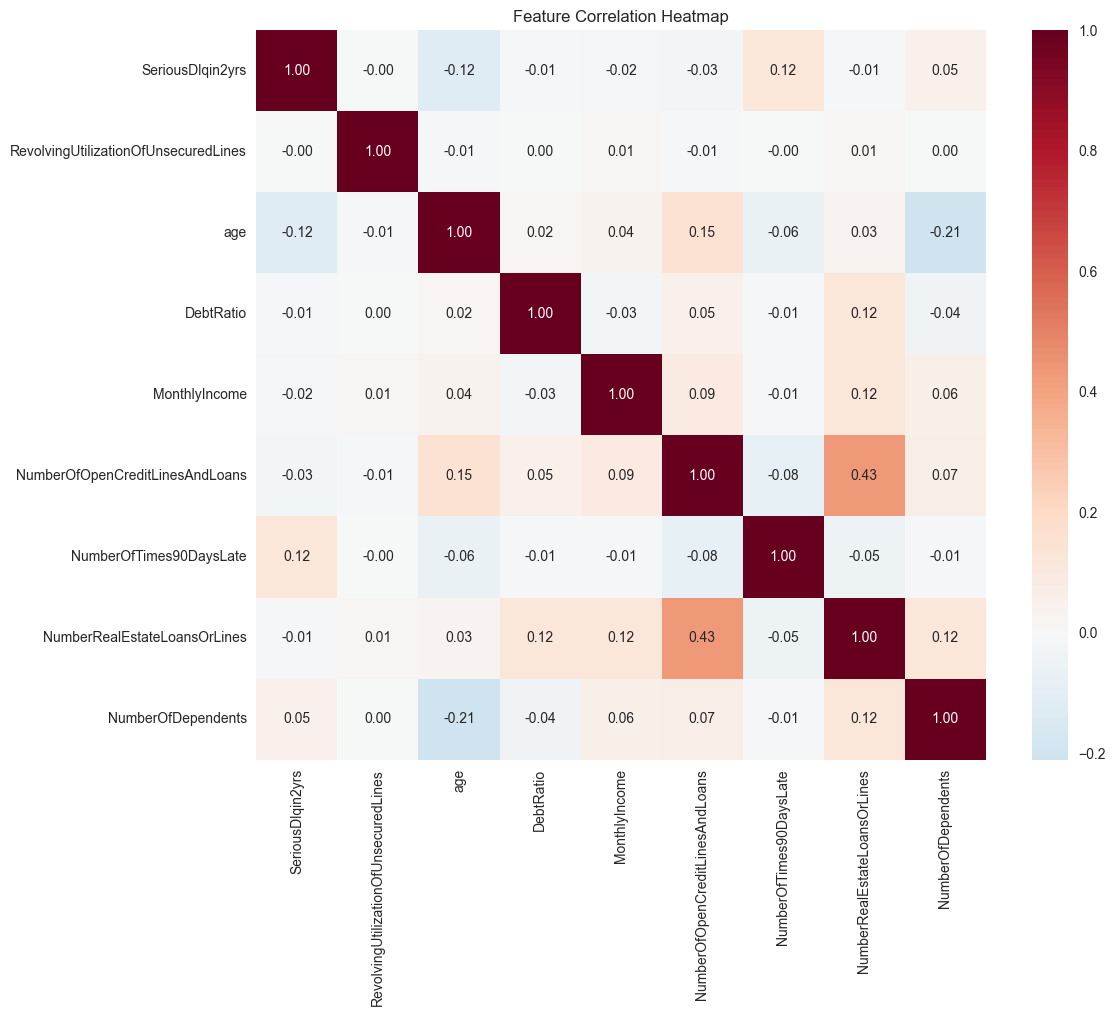

In [20]:
# 5. Correlation heatmap (numeric features only)
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr().round(2)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, square=True, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


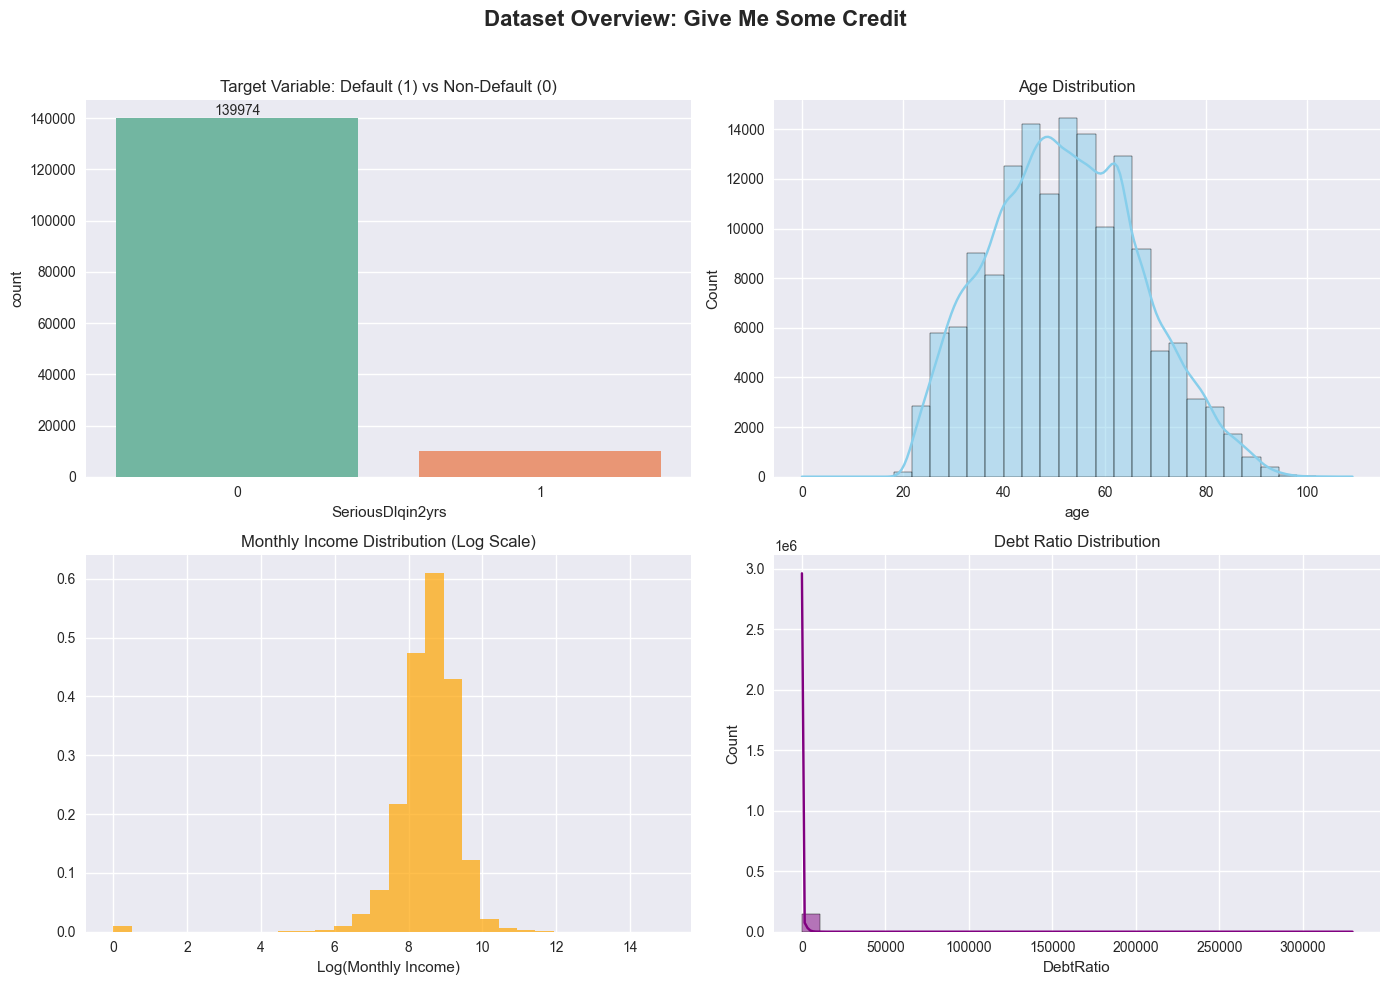

In [21]:
# Additional overview subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Dataset Overview: Give Me Some Credit", fontsize=16, fontweight='bold')

# Target Variable Distribution (bar with labels)
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title("Target Variable: Default (1) vs Non-Default (0)")
axes[0, 0].bar_label(axes[0, 0].containers[0])

# Age Distribution (histogram with KDE)
sns.histplot(df['age'], bins=30, kde=True, color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title("Age Distribution")

# Monthly Income Distribution (histogram with KDE, log scale)
df_income_pos = df[df['MonthlyIncome'] > 0]['MonthlyIncome']
axes[1, 0].hist(np.log(df_income_pos), bins=30, density=True, color='orange', alpha=0.7)
axes[1, 0].set_title("Monthly Income Distribution (Log Scale)")
axes[1, 0].set_xlabel("Log(Monthly Income)")

# Debt Ratio Distribution (histogram with KDE)
sns.histplot(df['DebtRatio'], bins=30, kde=True, color='purple', ax=axes[1, 1])
axes[1, 1].set_title("Debt Ratio Distribution")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 5. Train-Test Split

In [22]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# 6. Train-Only Data Preprocessing and Parameter Setup

In [23]:
# Train-only Preprocessing
age_bins = [0, 25, 35, 45, 55, 65, 120]
train_age_binned = pd.cut(X_train['age'].clip(0, 120), bins=age_bins, include_lowest=True)

income_median_by_age = X_train.groupby(train_age_binned)['MonthlyIncome'].median()
global_income_median = float(X_train['MonthlyIncome'].median())
dependents_median = float(X_train['NumberOfDependents'].median())
dependents_max = 8
util_cap = float(X_train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.999))
debt_cap = float(X_train['DebtRatio'].quantile(0.999))

params = {
    'age_bins': age_bins,
    'income_median_by_age': income_median_by_age,
    'global_income_median': global_income_median,
    'dependents_median': dependents_median,
    'dependents_max': dependents_max,
    'util_cap': util_cap,
    'debt_cap': debt_cap
}
joblib.dump(params, "preprocessing_params.pkl")


['preprocessing_params.pkl']

# 7. Data Preprocessing Function and Transformation

In [24]:
def preprocess(df_in: pd.DataFrame, p: dict) -> pd.DataFrame:
    d = df_in.copy()
    # Flags
    d['Income_missing'] = d['MonthlyIncome'].isna().astype(int)
    d['Deps_missing'] = d['NumberOfDependents'].isna().astype(int)
    # Impute income (age-binned -> global)
    age_binned = pd.cut(d['age'].clip(0,120), bins=p['age_bins'], include_lowest=True)
    d['MonthlyIncome'] = d['MonthlyIncome'].fillna(
        d['age'].map(lambda x: p['income_median_by_age'].get(pd.cut([x], bins=p['age_bins'], include_lowest=True)[0], np.nan))
    )
    d['MonthlyIncome'].fillna(p['global_income_median'], inplace=True)
    # Dependents
    d['NumberOfDependents'] = (
        d['NumberOfDependents'].fillna(p['dependents_median'])
        .round().clip(0, p['dependents_max']).astype(int)
    )
    # Clip outliers
    d['RevolvingUtilizationOfUnsecuredLines'] = d['RevolvingUtilizationOfUnsecuredLines'].clip(0, p['util_cap'])
    d['DebtRatio'] = d['DebtRatio'].clip(0, p['debt_cap'])
    return d

X_train_p = preprocess(X_train, params)
X_test_p  = preprocess(X_test, params)
# Log1p transform for income stability 
X_train_p['MonthlyIncome'] = np.log1p(X_train_p['MonthlyIncome'])
X_test_p['MonthlyIncome']  = np.log1p(X_test_p['MonthlyIncome'])
# Save feature order 
feature_order = X_train_p.columns.tolist()
joblib.dump(feature_order, "feature_order.pkl")

['feature_order.pkl']

# 8.1 Model Training – Random Forest Classifier

In [25]:
# RF 
rf = RandomForestClassifier(n_estimators=500, max_depth=12, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_p, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=500,
                       n_jobs=-1, random_state=42)

# 8.2 Model Training – XGBoost Classifier

In [26]:

imbalance = (y_train == 0).sum() / max(1, (y_train == 1).sum())
xgb = XGBClassifier(
    n_estimators=800, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=imbalance, eval_metric='logloss',
    random_state=42, n_jobs=-1
)
xgb.fit(X_train_p, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=-1,
              num_parallel_tree=None, ...)

# 8.3 Model Training – LightGBM Classifier

In [27]:

# Updated LightGBM: Reduced scale_pos_weight, more regularization, and calibration
lgb_base = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=20,  # Lowered from 31 to reduce overfitting
    min_child_samples=50,  # Added: Minimum samples per leaf for stability
    scale_pos_weight=imbalance * 0.5,  # Tempered: Halve the weight to avoid over-boosting positives
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_base.fit(X_train_p, y_train)

# Calibrate probabilities (Isotonic for small data, or Platt for larger)
lgb_model = CalibratedClassifierCV(lgb_base, method='isotonic', cv=5)
lgb_model.fit(X_train_p, y_train)


CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(colsample_bytree=0.8,
                                                learning_rate=0.05, max_depth=6,
                                                min_child_samples=50,
                                                n_estimators=800, n_jobs=-1,
                                                num_leaves=20, random_state=42,
                                                reg_alpha=0.1, reg_lambda=0.1,
                                                scale_pos_weight=np.float64(6.9807637503562265),
                                                subsample=0.8, verbose=-1),
                       method='isotonic')

# 8.4 Model Training – ensemble Classifier

In [28]:
from sklearn.ensemble import VotingClassifier

# Create and train ensemble (soft voting for probability averaging)
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('lgb', lgb_model)
    ],
    voting='soft',  # Averages predicted probabilities
    n_jobs=-1
)

ensemble.fit(X_train_p, y_train)

# Save ensemble
joblib.dump(ensemble, "ensemble_model.pkl")


['ensemble_model.pkl']

# 9. Model Evaluation

In [30]:
def eval_probs(name, model, X_test_mat, y_true):
    proba = model.predict_proba(X_test_mat)[:,1]
    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)
    # Compute accuracy at 0.5 threshold
    y_pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    print(f"{name}: ROC-AUC={roc:.3f}, PR-AUC={pr:.3f}, Accuracy={acc:.3f}")
    return {'roc_auc': float(roc), 'pr_auc': float(pr), 'accuracy': float(acc)}

results = {}
results['RandomForest'] = eval_probs('RandomForest', rf, X_test_p, y_test)
results['XGBoost'] = eval_probs('XGBoost', xgb, X_test_p, y_test)
results['LightGBM'] = eval_probs('LightGBM', lgb_model, X_test_p, y_test)


RandomForest: ROC-AUC=0.829, PR-AUC=0.326, Accuracy=0.826
XGBoost: ROC-AUC=0.819, PR-AUC=0.333, Accuracy=0.818
LightGBM: ROC-AUC=0.835, PR-AUC=0.353, Accuracy=0.936


In [33]:
# Evaluate ensemble (add to results)
results['Ensemble'] = eval_probs('Ensemble', ensemble, X_test_p, y_test)

Ensemble: ROC-AUC=0.830, PR-AUC=0.345, Accuracy=0.903


In [32]:
# Build label separate from classification
m_income = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
debt_ratio_raw = df['DebtRatio'].clip(0, df['DebtRatio'].quantile(0.999))
start_balance = (debt_ratio_raw * m_income).clip(lower=0)
monthly_payment = (0.08 * m_income).clip(lower=1.0)

def simulate_months(balance, monthly_payment, apr=0.18, cap=24):
    r = apr/12.0
    months = 0
    b = max(0.0, float(balance))
    p = max(1.0, float(monthly_payment))
    while b > 1.0 and months < cap:
        b = b*(1+r) - p
        months += 1
    return months

np.random.seed(42)
df['MonthsToRepay_proxy'] = [
    simulate_months(B, P, apr=0.18, cap=24) for B, P in zip(start_balance, monthly_payment)
]

reg_features = [
    'RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines','NumberOfDependents'
]
Xr = df[reg_features].fillna(df[reg_features].median())
yr = df['MonthsToRepay_proxy']

Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.20, random_state=42)
reg = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
reg.fit(Xr_tr, yr_tr)
yr_pred = reg.predict(Xr_te)
rmse = mean_squared_error(yr_te, yr_pred)
r2 = r2_score(yr_te, yr_pred)
print(f"MonthsToRepay (proxy): RMSE={rmse:.2f} months | R2={r2:.3f}")


MonthsToRepay (proxy): RMSE=0.05 months | R2=0.999


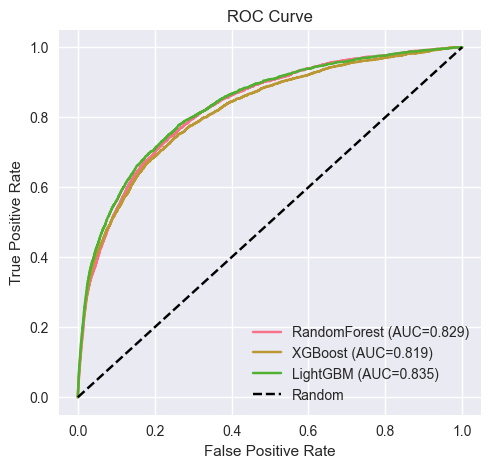

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
for name, model, X in [
    ("RandomForest", rf, X_test_p),
    ("XGBoost", xgb, X_test_p),
    ("LightGBM", lgb_model, X_test_p)
]:
    y_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()


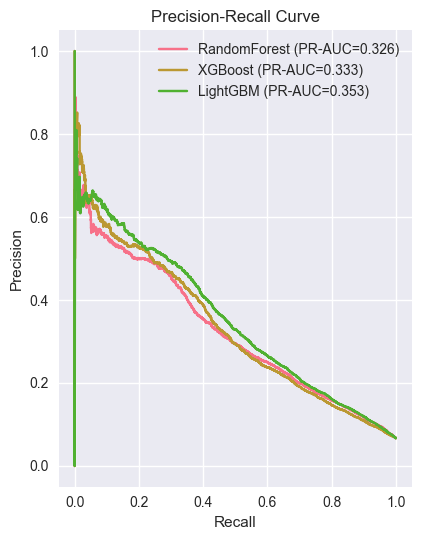

In [35]:
# PR Curve
plt.subplot(1, 2, 2)
for name, model, X in [
    ("RandomForest", rf, X_test_p),
    ("XGBoost", xgb, X_test_p),
    ("LightGBM", lgb_model, X_test_p)
]:
    y_proba = model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={average_precision_score(y_test, y_proba):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


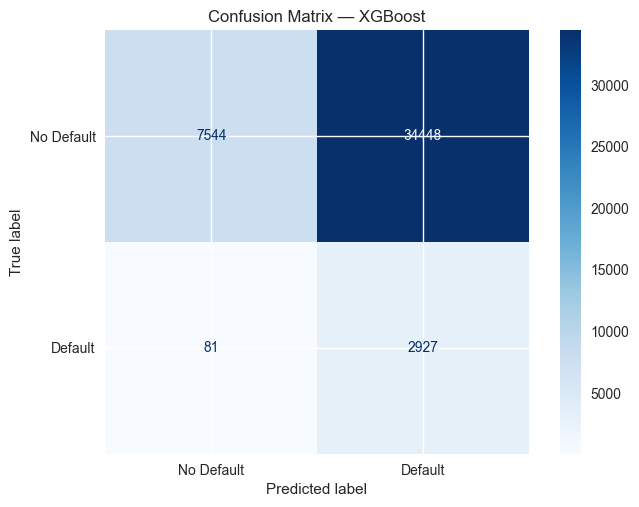

In [36]:
# Confusion Matrix for XGBoost (threshold 0.043 as in original)
y_pred_xgb = (xgb.predict_proba(X_test_p)[:, 1] >= 0.043).astype(int)
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — XGBoost")
plt.show()


# 10. Save Trained Models and Results

In [37]:
# Save models
joblib.dump(rf, "RandomForest_model.pkl")
joblib.dump(xgb, "XGBoost_model.pkl")
joblib.dump(lgb_model, "LightGBM_model.pkl")
joblib.dump(reg, "xgb_months_regressor_realistic.pkl")

# Save results
with open("model_results_simple.json","w") as f:
    json.dump({'classification': results, 'regression': {'rmse': float(rmse), 'r2': float(r2)}}, f, indent=2)

print("Training complete. Artifacts saved.")


Training complete. Artifacts saved.


In [20]:
pwd

'D:\\m hv'